# Assignment 3
by student: Alexander Onbysh

## Problem 4: Linear regression analysis
A telephone service provider aims to decrease the churn rate and analyses the data and service usage of 1000 clients. The following variables are used in the study  

**tenure** - month a client  
**age** - age in years  
**marital** status - marital status (1 - married, 0 - single)  
**address** - years at the current address  
**income** - household income in TEuro  
**ed** - education (5 categories: Did not complete high school; High school degree; Some college; College degree; Post-undergraduate degree)  
**retire** - retired (0 - no, 1 - yes)  
**gender** - gender (0 - male, 1 - female)  
**longmon** - long distance calls last month  
**wiremon** - internet use last month  
**churn** - 1 if the contract was terminated last month and 0 else 

The overall objective is to analyze the service usage using the long distance calls last month as the dependent variables and the remaining variables as explanatory.

### Installing libs

In [1]:
!pip install jupyter altair numpy pandas scipy altair vega_datasets sklearn statsmodels yellowbrick > /dev/null

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import CooksDistance
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors

alt.renderers.set_embed_options(theme='dark')

/Users/alexon/Projects/edu/masters/statistics/assignment-3/.env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


RendererRegistry.enable('default')

### Load data

In [3]:
df = pd.read_csv('telco.txt', sep='\t')
df_raw = df.copy()
df.head()
print(df.columns)

Index(['tenure', 'age', 'marital', 'address', 'income', 'ed', 'employ',
       'retire', 'gender', 'longmon', 'wiremon', 'churn'],
      dtype='object')


### Task 1
Have a closer look at the definitions of the variables and analyze which of them might require a separate treatment. Consider for example the variable ed. There are two possibilities how the variable ed can be included into the model (one with dummy variables, the other one without dummies). Think about these two approaches and suggest which approach is more appropriate. Motivate your decision.

In the dataset we have such categorical values:
- `marital` - bool
- `retire` - bool
- `ed` - categorical ('College degree', 'Post-undergraduate degree', 'Did not complete high school', 'High school degree', 'Some college')
- `gender` - bool
- `churn` - bool

Binary variables don't needed special treatment, string values like "Yes"/"No" should be converted to bool values. 
`ed` column has five unique values. We have two approaches how to handle these categories.

#### Label encoding
Encode each category with unique number values. 
pros:
- ordering of numbers could refer to some ordering of categorical values
cons:
- we can't determine the intervals between numbers to align with categories' "distances"

#### One hot encoding
For each category we add additional column with bool value. We set `True` if category present in the row else `False`.
pros:
- doesn't add ordering to categorical values
cons:
- we increase number of variables

Since `ed` column represent educational states of the person we could hardly 
set some ordering here. In this way, one hot encoding fits for this variable.

In [4]:
cat_vars = ['marital', 'retire', 'gender', 'churn']
for cat in cat_vars:
    df[cat] = df[cat].astype('category').cat.codes
    
one_hot = pd.get_dummies(df['ed'].astype('category'), prefix='ed')
df = pd.concat([df, one_hot], axis=1)
df.drop('ed', axis=1, inplace=True)

df.head()
df_with_cat = df.copy()

### Task 2
Consider now the dependent variable and the interval (metric) scaled explanatory variables. Plot these data and decide if you wish to transform these x-variables and if there is a need to transform the y variable. You can also use some measure of skewness to decide about y. The variable `wiremon` shows a very specific pattern. How would you take it into account?


In [5]:
def pairwise():
    columns = list(set(df.columns) - set(cat_vars) - set(one_hot.columns))
    return alt.Chart(df).mark_circle().encode(
            alt.X(alt.repeat("column"), type='quantitative'),
            alt.Y(alt.repeat("row"), type='quantitative'),
        ).properties(
            width=100,
            height=100
        ).repeat(
            row=columns,
            column=columns[::-1]
        ).interactive()
pairwise()

alt.RepeatChart(...)

In [6]:
df.skew()

tenure                             0.111860
age                                0.356664
marital                           -0.020031
address                            1.106246
income                             6.643272
employ                             1.061049
retire                             4.287311
gender                             0.068142
longmon                            2.966104
wiremon                            1.603680
churn                              1.014956
ed_College degree                  1.258466
ed_Did not complete high school    1.471304
ed_High school degree              0.943140
ed_Post-undergraduate degree       3.501277
ed_Some college                    1.433553
dtype: float64

From `skew` function and pairwise plot we could see that `address`, `income`, `longmon`, `wiremon` are skewed. To normalize variables we could take `log` or `sqrt` that depends on presence of zero values in variables.
`wiremon` has a lot of zeros values ($\approx 70\%$) this fact says that no intenet usage was logged during previous month. In this way we could create additional binary variable `wireon` that shows if customer is connected to the Internet. 

In [7]:
(df['wiremon'] == 0).sum() / len(df)

0.704

In [8]:
df['wireon'] = (df['wiremon'] != 0).astype(int)

In [9]:
skewed_cat = ['address', 'income', 'longmon', 'wiremon', 'address']
for cat in skewed_cat:
    df[cat] = np.sqrt(df[cat]) if (df[cat] == 0).any() else np.log(df[cat])
df.skew()

tenure                             0.111860
age                                0.356664
marital                           -0.020031
address                           -1.166131
income                             0.701345
employ                             1.061049
retire                             4.287311
gender                             0.068142
longmon                            0.166444
wiremon                            1.061664
churn                              1.014956
ed_College degree                  1.258466
ed_Did not complete high school    1.471304
ed_High school degree              0.943140
ed_Post-undergraduate degree       3.501277
ed_Some college                    1.433553
wireon                             0.895118
dtype: float64

In [10]:
pairwise()

alt.RepeatChart(...)

### Task 3
After making up your decision about the above two problems run a simple linear
regression. Pick up one of the regressors. Write down the corresponding hypothesis of
the t-test. Provide the formula for the test statistics, explain the components of the
formula and give the values for this components. Evaluate the goodness of the model.  
Explain in your own words the difference between $R$ and adjusted $R^2$.

In [11]:
X = df.drop('longmon', axis=1)
X = sm.add_constant(X)
y = df['longmon']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

/Users/alexon/Projects/edu/masters/statistics/assignment-3/.env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     165.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):          1.62e-256
Time:                        00:11:36   Log-Likelihood:                -480.25
No. Observations:                1000   AIC:                             992.5
Df Residuals:                     984   BIC:                             1071.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.9466      0.083     11.338      0.000       0.783       1.110
tenure                              0.0276      0.001     35.388      0.000       0.026       0.029
age                                -0.0016      0.002     -1.017      0.310      -0.005       0.002
marital                            -0.0694      0.026     -2.710      0.007      -0.120      -0.019
address                             0.0240      0.028      0.866      0.387      -0.030       0.078
income                              0.0209      0.027      0.786      0.432      -0.031       0.073
employ                              0.0016      0.002      0.679      0.497      -0.003       0.006
retire                              0.2520      0.080      3.161      0.002       0.096       0.408
gender                              0.0345      0.025      1.372      0.170      -0.015       0.084
wiremon                             0.0004      0.021      0.018      0.986      -0.040       0.041
churn                              -0.0393      0.031     -1.270      0.204      -0.100       0.021
ed_College degree                   0.2466      0.032      7.619      0.000       0.183       0.310
ed_Did not complete high school     0.1319      0.029      4.520      0.000       0.075       0.189
ed_High school degree               0.2218      0.026      8.542      0.000       0.171       0.273
ed_Post-undergraduate degree        0.1377      0.050      2.779      0.006       0.040       0.235
ed_Some college                     0.2088      0.030      7.005      0.000       0.150       0.267
wireon                             -0.0097      0.129     -0.075      0.940      -0.263       0.244
==============================================================================
Omnibus:                        2.341   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.310   Jarque-Bera (JB):                2.345
Skew:                          -0.050   Prob(JB):                        0.310
Kurtosis:                       3.215   Cond. No.                     9.97e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.63e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Lets use `address` as a tested regression.  
The null hypothesis is $H_0:\beta_{address} = 0$, in this way we try to reject the null hypothesis $H_1:\beta_{address}  \neq 0$.  
To calculate test statistic we will use the formula:  
<center>
    $t_{emp} = \frac{\hat{\beta_j} - \beta_j^*}{\sqrt{\hat{Var(\hat{\beta_j})}}}$
</center>
where $\hat{Var(\hat{\beta}_j)}$ is the $j$-th element of the mail diagonal of $\hat{\sigma}^2(\bar{X}X)^{-1}$
<center>
    $\hat{\beta} = N_{K + 1}(\beta, \sigma^2(\bar{X}X)^{-1})$
</center>

In [12]:
C = np.linalg.inv(X.T @ X)
std_b = np.sqrt(np.diag(C * model.mse_resid))


std_add = std_b[4]
beta_add = model.params[4]
t = beta_add / std_add
print(f'STD: {std_add}; Beta: {beta_add}; t-test: {t}')

# calculating probability
# one-tail probability
prob = 1 - stats.t(model.nobs - model.df_model - 1).cdf(t)
prob_2 = prob * 2
print(f'P = {prob_2}')

STD: 0.0277410615558222; Beta: 0.024020219398518464; t-test: 0.8658723946155975
P = 0.3867712047142571


To evaluate the goodness of the model we could use $R^2$ and $R_{adj}^2$ statistic.  
<center>
    $R^2 = \frac{ESS}{TSS} = 1 - \frac{\sum_{i=1}^N(y_i - \hat{y_i})^2}{\sum_{i=0}^N(y_i - \bar{y})^2}$
</center>

<center>
    $R_{ajd}^2 = 1 - \frac{(1 - R^2)(N - 1)}{N - p - 1}$
</center>
where $p$ - number ob predictors, $N$ - total sample size

$R^2$ measures the proportion of the variation in dependent variable explained by all of independent variables in the model. One of the main disadvantages is that $R^2$ increases with number of $p$.

$R_{adj}^2$ measures the proportion of variation explained by only those independent variables that really help in explaining the dependent variable. It penalizes for adding independent variable that do not help in predicting the dependent variable.

In [13]:
print(f'R^2 = {model.rsquared}')
print(f'R_adj^2 = {model.rsquared_adj}')

R^2 = 0.7161727146616812
R_adj^2 = 0.7118460792144508


### Task 4
Compute manually the predicted values from the above regression and the residuals. Make two plots: residuals vs. true $y$’s and predicted $y$’s vs. true $y$’s. What do you expect in both cases and why? Do the obtained figures support your expectations?

In [14]:
pred_val = np.asarray(X) @ np.asarray(model.params).T
true_val = df['longmon'].values.copy()
residual = true_val - pred_val

ols_data = pd.DataFrame({
    'prediction': pred_val,
    'true': true_val,
    'residual': residual
})

In [15]:
plot1 = alt.Chart(ols_data).mark_point().encode(
    x=alt.X('residual'),
    y=alt.Y('prediction'),
)
plot2 = alt.Chart(ols_data).mark_point().encode(
    x=alt.X('true'),
    y=alt.Y('prediction'),
)

plot1 | plot2

alt.HConcatChart(...)

#### predicton vs residual
We expect the distribution of error terms has zero mean and doesn’t depend on the independent variables X's. Thus, there must be no relationship between the X's and the error term.  

#### prediction vs true values
We expect the distribution should have positive trend due to the fact that predictions of the model should be higly correlated with the target values.

Both assumptions supported by plots.

### Task 5
If you wish to argue that education is insignificant and use the model with dummies than you have to check the simultaneous insignificance of all dummies which stem from the factor variable `ed`. Run a test for general linear hypothesis and conclude about the significance of `ed`. Write down the matrix and the vector needed in the hypothesis.

In [16]:
restricted_X = df.drop(['longmon', 'ed_College degree', 'ed_Did not complete high school', 'ed_High school degree', 'ed_Post-undergraduate degree', 'ed_Some college'], axis=1)
restricted_X = sm.add_constant(restricted_X)

restricted_model = sm.OLS(y, restricted_X).fit()
model.compare_f_test(restricted_model)

(2.7135145227036626, 0.02883807363139406, 4.0)

$P$-value is $\approx 0.0288$ so we have strong evidence that $H_0$ should be rejected, so variable `ed` is significant.

### Task 6
Provide an economic interpretation for the parameters of address, ed, and retire. Neglect the possible insignificance and keep in mind possible transformations of the variables.

`address` - we applied logarithm transormation to this variable and with change of this value by 1 we'd expect target value changed by $\beta_{address}$  
`ed` - we applied one hot encoding to the `ed` variable and if education is specified we expect target variable to change by $100 \times \beta_{address}$  
`retire` - we haven't applied any transformation to `retire` variable so with change by 1 we'd expect target value changed by $100 \times \beta_{address}$  

### Task 7
Compute the $95\%$ confidence intervals for the parameters of address and income and provide its economic meaning. Relate the CIs to the tests of significance, i.e. how would you use these intervals to decide about the significance of the corresponding explanatory variables? The CIs are computed relying on the assumption, that the residuals follow normal distribution. Is this assumption fulfilled? Run an appropriate goodness-of-fit test.

#### CI

In [17]:
print('confidence interval')
model.conf_int().loc[['address', 'income']]

confidence interval


,0,1
address,-0.030418,0.078459
income,-0.031349,0.073239


#### Significance

"Tight" confidence intervals could say that statistical significance if the model is high.

#### Residuals (Lilliefors Test)
The Lilliefors test is a test for normality. It is an improvement on the Kolomogorov-Smirnov (K-S) test — correcting the K-S for small values at the tails of probability distributions — and is therefore sometimes called the K-S D test.

In [18]:
lilliefors(model.params, dist='norm')

(0.2383909142340277, 0.011181622913722267)

$0.0111816 < 0.05$ that confirms that residuals are normaly distributed.

### Task 8
Many of the variable appear insignificant and we should find the smallest model, which still has a good explanatory power. Choose this model using stepwise model selection (either based on the tests for R2 or using AIC/BIC). Pick up the last step of the model selection procedure and explain in details how the method/approach works (or is implemented in your software). Work with this model in all the remaining steps.

I have used ranking feature estimator form sklearn.  
Initially model is trained on all features from the set. After the first step the less sugnificant feature is pruned and process of training repeats. Internaly it uses `_feature_importances_` field of the estimator. For our case it's $R^2$

In [19]:
selector = RFE(LinearRegression())
selector.fit(X, y)
print(selector.ranking_)
X = X.iloc[:, selector.ranking_ <= 5]
X_reduced = X.copy()

[10  1  7  1  5  1  8  1  1  9  1  2  1  3  1  4  6]


In [20]:
model = sm.OLS(y, X).fit()

### Task 9
Sometimes data contains outliers which induces bias in the parameter estimates. Check for outliers using Cook’s distance and leverage. Have a closer look at the observation with the highest leverage (regardless if it is classified as an outlier or not). What makes this observation so outstanding (you may have a look at Box-plots for interval scaled variables or at the frequencies for binary/ordinal variables?

/Users/alexon/Projects/edu/masters/statistics/assignment-3/.env/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/alexon/Projects/edu/masters/statistics/assignment-3/.env/lib/python3.7/site-packages/yellowbrick/regressor/influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  self.distance_, linefmt=self.linefmt, markerfmt=self.markerfmt


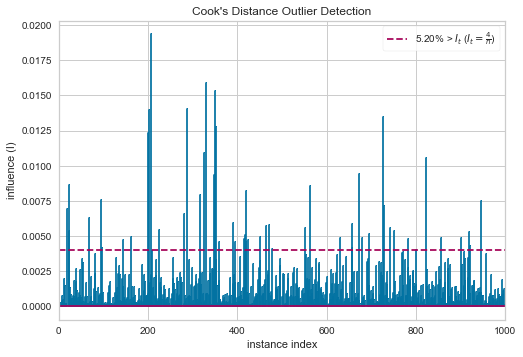

In [21]:
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show()

In [22]:
influence = model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance
df_raw[leverage == np.max(leverage)]

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
292,72,63,Married,29,15,Post-undergraduate degree,31,Yes,Male,20.6,0.0,No


In [23]:
p1 = alt.Chart(df).mark_boxplot().encode(
    x='age:O',
    y='income:Q'
)
p2 = alt.Chart(df).mark_boxplot().encode(
    x='age:O',
    y='address:Q'
)
p3 = alt.Chart(df).mark_boxplot().encode(
    x='age:O',
    y='employ:Q'
)
alt.vconcat(p1, p2, p3)

alt.VConcatChart(...)

We can see that income $15$ is uncommon for this income group and it's outlire based on boxplot. Employ also higher that expected for this group. Since outliers are selected based on multiple variables this record has the biggest leverage in multidimetional space.

### Task 10
Frequently data is missing. Pick up 5 rows in the data set and delete the value for address. Implement at least two approaches to fill in these values. Write down the corresponding formulas/model and give motivation for your approach. If you use stan- dard routines then check how exactly the data imputation is implemented. How would you proceed if the value of the binary variable retire is missing? Implementation is not required.

In [24]:
X.loc[[10, 12, 56, 78, 100], 'address'] = pd.np.nan
X.head(15)

,tenure,marital,address,income,retire,gender,churn,ed_College degree,ed_Did not complete high school,ed_High school degree,ed_Post-undergraduate degree,ed_Some college
1,13,0,1.732051,4.158883,0,1,1,1,0,0,0,0
2,11,0,1.626577,4.912655,0,1,1,0,0,0,1,0
3,68,0,2.213364,4.753590,0,0,0,0,1,0,0,0
4,33,1,1.861210,3.496508,0,0,1,0,0,1,0,0
5,23,0,1.732051,3.401197,0,1,0,0,1,0,0,0
6,41,1,2.030543,4.356709,0,0,0,0,0,1,0,0
7,45,0,1.189207,2.944439,0,0,1,0,0,1,0,0
8,38,1,1.495349,4.330733,0,1,0,0,0,1,0,0
9,45,0,1.626577,5.111988,0,1,0,1,0,0,0,0
10,68,0,NaN,4.276666,0,1,0,0,1,0,0,0


1. Take median as a default value
Just find a median of the variable and replace all missed valued with this median

In [25]:
median = X['address'].fillna(X['address'].median())
print(f'L2: {np.linalg.norm(median - df["address"])}')

L2: 1.188924319706457


2. Regression model. Train linear regression with `address` target. Predict missed values of address with regression

In [26]:
missed_idx = X.index.isin([10, 12, 56, 78, 100])
droped_X = X[~missed_idx]
y = droped_X['address']
addr_X = droped_X.drop('address', axis=1)

addr_model = sm.OLS(y, addr_X).fit()
predicted = addr_model.predict(X[missed_idx].drop('address', axis=1))

print(f'L2: {np.linalg.norm(predicted - df[missed_idx]["address"])}')

L2: 0.9720483599204033


As we can see regression model performs better that simple mean replacement in terms of $L_2$ norm.

`retires` missed values replacemnt:
- use logistic regression for prediction of the missed values
- use clustering based on other variables and assign missed value to the closest cluster
- just drop the records :)

### Task 11
We consider now the model you have worked with so far and the model with original y if you applied some transformation OR the model with log(y) if you have not transformed y. Run an appropriate test to decide which of the models is superior. Explain, the idea of the test and why you cannot make a similar decision using AIC/BIC, etc.

#### Use $R_{adj}^2$

In [27]:
# model without log transformation
X = df.drop('longmon', axis=1)
X = sm.add_constant(X)
y = df_raw['longmon']

model_without_log = sm.OLS(y, X).fit()
model_without_log.summary()

/Users/alexon/Projects/edu/masters/statistics/assignment-3/.env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     79.86
Date:                Mon, 23 Dec 2019   Prob (F-statistic):          2.56e-158
Time:                        00:11:39   Log-Likelihood:                -3358.6
No. Observations:                1000   AIC:                             6749.
Df Residuals:                     984   BIC:                             6828.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.4119      1.485     -0.277      0.782      -3.326       2.502
tenure                              0.3077      0.014     22.152      0.000       0.280       0.335
age                                -0.0843      0.029     -2.954      0.003      -0.140      -0.028
marital                            -0.9857      0.456     -2.163      0.031      -1.880      -0.092
address                             0.8550      0.493      1.733      0.083      -0.113       1.823
income                              0.4398      0.474      0.928      0.354      -0.490       1.370
employ                              0.1300      0.042      3.087      0.002       0.047       0.213
retire                              8.7029      1.418      6.139      0.000       5.921      11.485
gender                              0.3883      0.448      0.868      0.386      -0.490       1.266
wiremon                             0.0846      0.368      0.230      0.818      -0.637       0.806
churn                               0.2103      0.551      0.382      0.703      -0.871       1.292
ed_College degree                   0.6058      0.576      1.053      0.293      -0.523       1.735
ed_Did not complete high school    -0.6747      0.519     -1.300      0.194      -1.693       0.344
ed_High school degree               0.5333      0.462      1.155      0.248      -0.373       1.439
ed_Post-undergraduate degree       -0.8274      0.881     -0.939      0.348      -2.556       0.901
ed_Some college                    -0.0491      0.530     -0.093      0.926      -1.089       0.991
wireon                             -0.8804      2.297     -0.383      0.702      -5.387       3.626
==============================================================================
Omnibus:                      727.626   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19101.404
Skew:                           3.013   Prob(JB):                         0.00
Kurtosis:                      23.546   Cond. No.                     9.97e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.63e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     226.2
Date:                Mon, 23 Dec 2019   Prob (F-statistic):          7.04e-261
Time:                        00:11:39   Log-Likelihood:                -480.89
No. Observations:                1000   AIC:                             985.8
Df Residuals:                     988   BIC:                             1045.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
tenure                              0.0276      0.001     37.679      0.000       0.026       0.029
marital                            -0.0694      0.026     -2.715      0.007      -0.120      -0.019
address                             0.0143      0.026      0.560      0.576      -0.036       0.065
income                              0.0249      0.018      1.387      0.166      -0.010       0.060
retire                              0.2386      0.064      3.722      0.000       0.113       0.364
gender                              0.0326      0.025      1.302      0.193      -0.017       0.082
churn                              -0.0403      0.031     -1.311      0.190      -0.101       0.020
ed_College degree                   1.1395      0.078     14.594      0.000       0.986       1.293
ed_Did not complete high school     1.0316      0.075     13.752      0.000       0.884       1.179
ed_High school degree               1.1198      0.074     15.183      0.000       0.975       1.265
ed_Post-undergraduate degree        1.0275      0.090     11.381      0.000       0.850       1.205
ed_Some college                     1.1058      0.077     14.380      0.000       0.955       1.257
==============================================================================
Omnibus:                        2.261   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                2.273
Skew:                          -0.042   Prob(JB):                        0.321
Kurtosis:                       3.218   Cond. No.                         556.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that for model without `log` transformation of `longmon` $ R_{adj}^2 =  0.542$ and for model with `log` transformantion $R_{adj}^2 = 0.713$.

#### J-test

In [29]:
y = df['longmon']
X_comp = np.stack([model.predict(), model_without_log.predict()], axis=1)

comp_model = sm.OLS(y, X_comp).fit()
comp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                longmon   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          1.677e+04
Date:                Mon, 23 Dec 2019   Prob (F-statistic):                        0.00
Time:                        00:11:39   Log-Likelihood:                         -480.87
No. Observations:                1000   AIC:                                      965.7
Df Residuals:                     998   BIC:                                      975.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9964      0.018     56.067      0.000       0.961       1.031
x2             0.0006      0.003      0.216      0.829      -0.005       0.006
==============================================================================
Omnibus:                        2.212   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                2.212
Skew:                          -0.043   Prob(JB):                        0.331
Kurtosis:                       3.214   Cond. No.                         20.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on $J_{test}$ the log model is superior. The test is based on the linear model which is traied on the results of log transformed model and non transformed. The idea is to look into sugnificance of the contribution of the non-log transfomed model. As we can see from results for $x_1$ we have $0.9964$ coef, and for $x_2$ we have $0.003$. This shows that log model is superior.

### Task 12
We compare the predictive ability of the estimated regression. Consider the model you worked so far and the original model with the same y but without transformation and selection of features. Compare the two models using leave-one-out CV and 5-fold CV. Explain the idea of this technique with formulas and draw a conclusion about the predictive ability of the models.

In [30]:
selected_model = LinearRegression()
original_model = LinearRegression()

#### selected model

In [31]:
selected_model_lou = cross_val_predict(LinearRegression(), X_reduced, df['longmon'], cv=len(X))
selected_5_fold = cross_val_predict(LinearRegression(), X_reduced, df['longmon'], cv=5)
print(f'lou: {r2_score(df["longmon"], selected_model_lou)}')
print(f'lou: {r2_score(df["longmon"], selected_5_fold)}')

lou: 0.7086646938912946
lou: 0.7081842840005841


#### without feature selection

In [32]:
model_lou = cross_val_predict(LinearRegression(), df_with_cat.drop('longmon', axis=1), df['longmon'], cv=len(df_raw))
model_5_fold = cross_val_predict(LinearRegression(),  df_with_cat.drop('longmon', axis=1), df['longmon'], cv=5)
print(f'lou: {r2_score(df["longmon"], model_lou)}')
print(f'lou: {r2_score(df["longmon"], model_5_fold)}')

lou: 0.708434229996384
lou: 0.7070550331207983


#### K-fold CV
The data set is divided into k subsets. One of the k subsets is used as the test set and the other k-1 subsets are put together to form a training set. Then the average error across all k trials is computed. The advantage of this method is that it matters less how the data gets divided. Every data point gets to be in a test set exactly once, and gets to be in a training set k-1 times.   
Error in cross validation is calculated by:  
$CV(\hat{f}) = \frac{1}{N} \sum_{i=1}^N L(y_i, \hat{f}^{-K(i)}(x_i))$
#### leave-one-out CV
Leave-one-out cross validation is K-fold cross validation with K equal to the number of data points in the set. The function approximator is trained on all the data except for one point and a prediction is made for that point. 

## Problem 5
## Shifts of the variables, demeaned regression
Consider a linear regression model for a dependent variable $y_t$ that has a sample mean of $17.21$. Suppose that we create a new variable $y_t^∗ = y_t + 10$ and run the same linear regression using $y_t^∗$ instead of $y_t$ as a regressand.

### Task 1
How are $R^2$ and the estimate of the constant term related in the two regressions? What if we use $y_t^∗ = y_t − 10$ instead?

$R^2$ should not chage since $+10$ change in dependent varable does not change the variance of the distribution but only the mean. The mean in this way would be $27.21$ and esimated constant term would be $C^* = C + 10$.  
The same for $-10$. The mean would be $7.21$ and constant term $C^* = C - 10$  

### Task 2
What if we do the same with one or all of the regressors?

In case when we change all regressors by constant that is the same as we change target varaible. The constant term will change by constant and $R^2$ will not change.  
$Y = \alpha + \beta (X + C) + e \equiv Y = \alpha + \beta X + \beta C + e \equiv Y = \hat{\alpha} + \beta X + e$

In case when we change one regressor by constant we will have the same weights as for not changed variable since:  
$Y = \alpha + (\beta_1 x_1 + \beta_2 x_2 + \cdots \beta_k (C + x_k) \cdots \beta_n x_n) + e \equiv 
\alpha + C \beta_k + (\beta_1 x_1 + \beta_2 x_2 + \cdots \beta_k x_k \cdots \beta_n x_n) + e \equiv
\hat{\alpha} + \beta X + e
$

### Task 3
Consider a demeaned regression, i.e. center the regressors and the regressand to have zero mean. How does it influence the estimates?

Scales or shifts of variables should not affect regressor's estimations since multiplication (change of variance) will go to the $\beta$ term, and shifts (change of mean) to the $\alpha$ term. So, for simple linear regression normalization have no effect on the estimation. 
However, such regression will work only if validation dataset has the same distribution as the train set. If validation dataset has change in variance or in bias then model produces incorrect results but model trained on scaled variables doesn't.

Also, if we would like to use regularization term then normalization is a must since magnitude of weights will affect regularization term.